Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=b16df63698a176e447c064a06d4695ac5b86b3e6871348159bc572eac6064204
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.3 MB/s 
     |████████████████████████████████| 7.6 MB 55.1 MB/s 
     |████████████████████████████████| 163 kB 76.2 MB/s 
[4957, 4918, 4964, 4805, 3923, 2588, 5326, 2438, 3652, 2180,

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-21 05:09:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-21 05:09:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-21 05:09:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3488 words (3112 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 100)          660100    
                                                                 
 bidirectional (Bidirectiona  (None, 140, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 140, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 140, 43)           1849      
                                                                 
Total params: 831,392
Trainable params: 831,392
Non-trainable params:

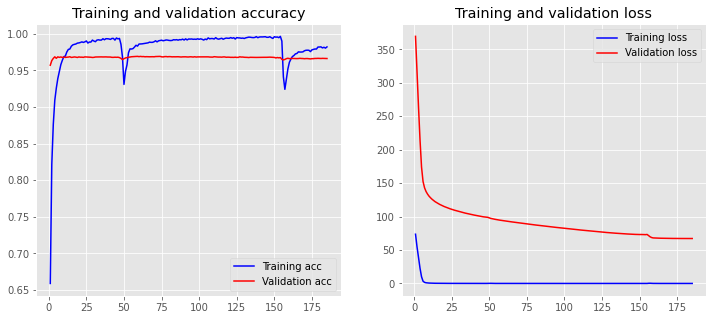

6/6 [==============================] - 3s 75ms/step
F1-score: 69.4%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8543689320388349,0.8979591836734694,0.8756218905472637,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.3902439024390244,0.5925925925925926,0.47058823529411764,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5151515151515151,0.85,0.6415094339622641,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.8842105263157894,0.9655172413793104,0.9230769230769231,87.0
Material,0.5864661654135338,0.740506329113924,0.6545454545454545,316.0
Material-Descriptor,0.46808510638297873,0.4943820224719101,0.4808743169398907,89.0
Meta,0.16666666666666666,0.23076923076923078,0.1935483870967742,13.0
Nonrecipe-Material,0.3333333333333333,0.32,0.32653061224489793,25.0
Number,0.9205607476635514,0.9292

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3494 words (3117 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 140, 100)          661200    
                                                                 
 bidirectional_1 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 832,492
Trainable params: 832,492
Non-trainable param

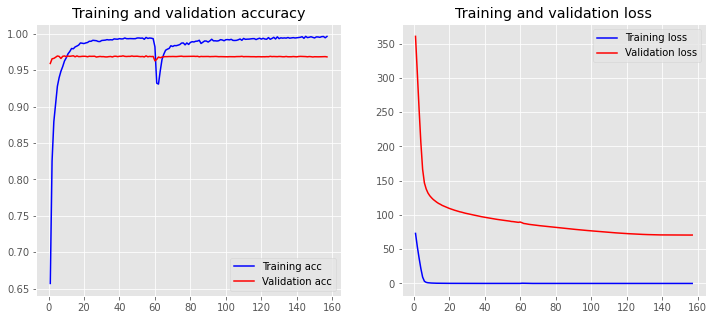

6/6 [==============================] - 3s 71ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.07692307692307693,0.14285714285714285,0.1,7.0
Amount-Unit,0.8476190476190476,0.9081632653061225,0.876847290640394,98.0
Apparatus-Descriptor,0.6666666666666666,0.4444444444444444,0.5333333333333333,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5652173913043478,0.48148148148148145,0.52,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9431818181818182,0.9540229885057471,0.9485714285714286,87.0
Material,0.6297297297297297,0.7373417721518988,0.6793002915451896,316.0
Material-Descriptor,0.5333333333333333,0.5393258426966292,0.5363128491620112,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3494 words (3113 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 140, 100)          660800    
                                                                 
 bidirectional_2 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 832,092
Trainable params: 832,092
Non-trainable param

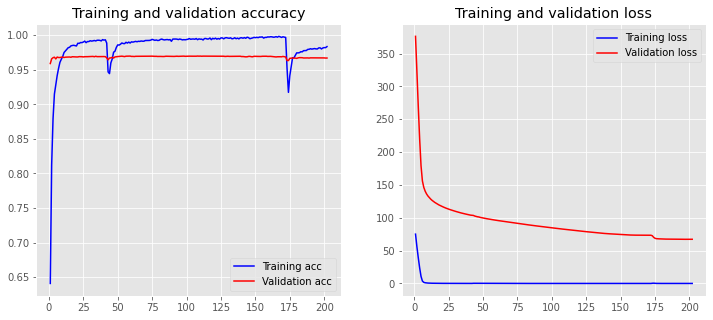

6/6 [==============================] - 3s 72ms/step
F1-score: 69.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8415841584158416,0.8673469387755102,0.8542713567839196,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.5,0.48148148148148145,0.49056603773584906,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5714285714285714,0.8,0.6666666666666666,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6049046321525886,0.7025316455696202,0.6500732064421669,316.0
Material-Descriptor,0.4444444444444444,0.4943820224719101,0.4680851063829787,89.0
Meta,0.35714285714285715,0.38461538461538464,0.37037

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3489 words (3108 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 140, 100)          659800    
                                                                 
 bidirectional_3 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 831,092
Trainable params: 831,092
Non-trainable param

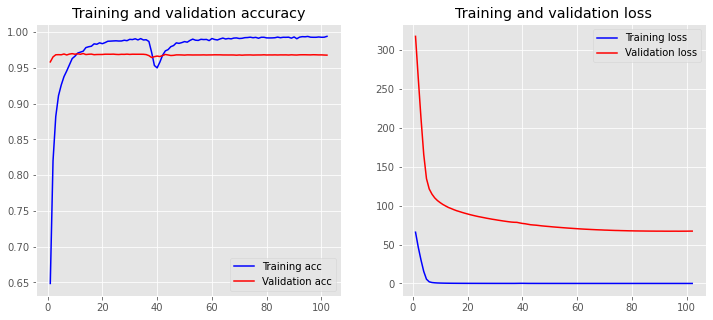

6/6 [==============================] - 3s 71ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8504672897196262,0.9285714285714286,0.8878048780487805,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.07692307692307693,0.125,13.0
Brand,0.4473684210526316,0.6296296296296297,0.5230769230769231,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5294117647058824,0.9,0.6666666666666667,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9438202247191011,0.9655172413793104,0.9545454545454545,87.0
Material,0.5958549222797928,0.7278481012658228,0.6552706552706553,316.0
Material-Descriptor,0.5052631578947369,0.5393258426966292,0.5217391304347827,89.0
Meta,0.26666666666666666,0.307692307692

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3491 words (3119 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 140, 100)          661100    
                                                                 
 bidirectional_4 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 832,392
Trainable params: 832,392
Non-trainable param

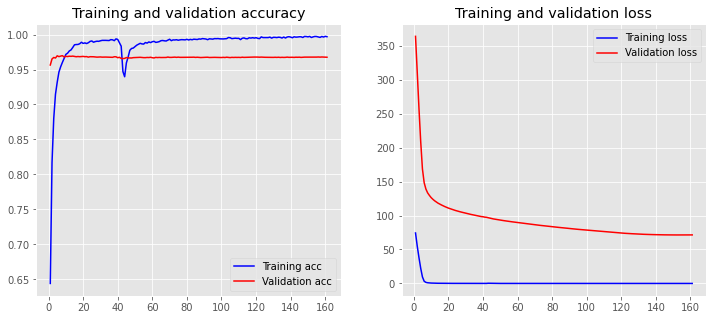

6/6 [==============================] - 4s 74ms/step
F1-score: 70.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.14285714285714285,0.2857142857142857,0.19047619047619047,7.0
Amount-Unit,0.822429906542056,0.8979591836734694,0.8585365853658536,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.56,0.5185185185185185,0.5384615384615384,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5517241379310345,0.8,0.6530612244897959,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.6272965879265092,0.7563291139240507,0.6857962697274033,316.0
Material-Descriptor,0.45,0.5056179775280899,0.47619047619047616,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Material,0.25,0.12,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3492 words (3111 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 140, 100)          660400    
                                                                 
 bidirectional_5 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 831,692
Trainable params: 831,692
Non-trainable param

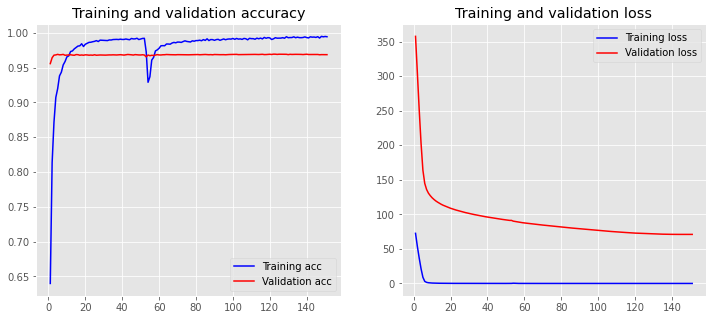

6/6 [==============================] - 3s 73ms/step
F1-score: 70.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.1111111111111111,0.14285714285714285,0.125,7.0
Amount-Unit,0.8640776699029126,0.9081632653061225,0.8855721393034826,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.5,0.4444444444444444,0.47058823529411764,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5294117647058824,0.9,0.6666666666666667,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.6143250688705234,0.7056962025316456,0.6568483063328424,316.0
Material-Descriptor,0.4639175257731959,0.5056179775280899,0.4838709677419355,89.0
Meta,0.3076923076923077,0.3076923076923077,0.3076923076923077,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3479 words (3111 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 140, 100)          659100    
                                                                 
 bidirectional_6 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 830,392
Trainable params: 830,392
Non-trainable param

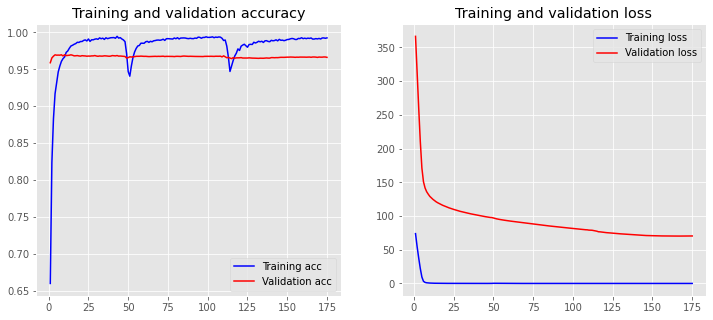

6/6 [==============================] - 3s 77ms/step
F1-score: 70.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.07692307692307693,0.14285714285714285,0.1,7.0
Amount-Unit,0.839622641509434,0.9081632653061225,0.8725490196078433,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.5,0.5925925925925926,0.5423728813559322,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6296296296296297,0.85,0.723404255319149,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6071428571428571,0.7531645569620253,0.6723163841807909,316.0
Material-Descriptor,0.5054945054945055,0.5168539325842697,0.5111111111111112,89.0
Meta,0.23529411764705882,0.3076923076923077,0.26666666666666666,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3489 words (3117 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 140, 100)          660700    
                                                                 
 bidirectional_7 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 831,992
Trainable params: 831,992
Non-trainable param

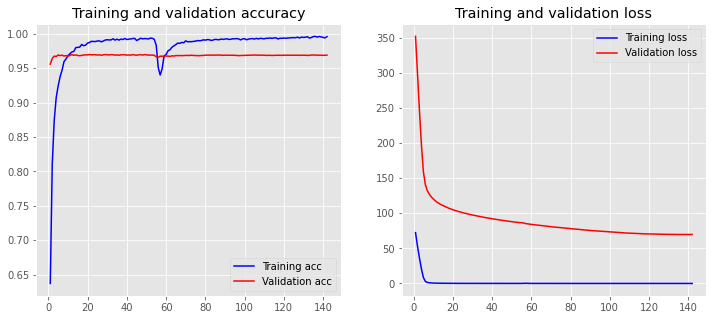

6/6 [==============================] - 4s 75ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8090909090909091,0.9081632653061225,0.8557692307692307,98.0
Apparatus-Descriptor,0.7142857142857143,0.5555555555555556,0.6250000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.07692307692307693,0.125,13.0
Brand,0.5625,0.6666666666666666,0.6101694915254238,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9545454545454546,0.9655172413793104,0.96,87.0
Material,0.6373937677053825,0.7120253164556962,0.672645739910314,316.0
Material-Descriptor,0.45918367346938777,0.5056179775280899,0.48128342245989303,89.0
Meta,0.17647058823529413,0.23076923076923078,0.20000000000000004,13.0
Nonrecip

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3480 words (3111 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 140, 100)          659200    
                                                                 
 bidirectional_8 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 830,492
Trainable params: 830,492
Non-trainable param

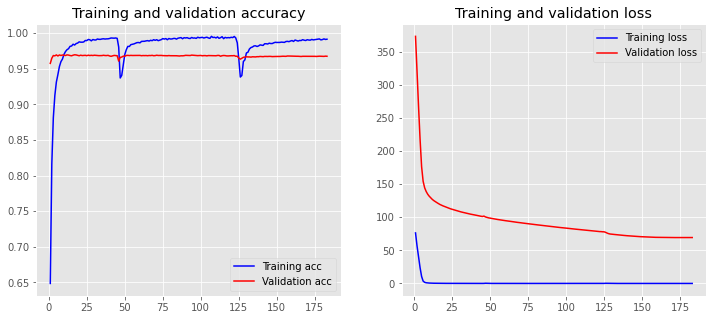

6/6 [==============================] - 3s 74ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.16666666666666666,0.2857142857142857,0.2105263157894737,7.0
Amount-Unit,0.839622641509434,0.9081632653061225,0.8725490196078433,98.0
Apparatus-Descriptor,0.375,0.3333333333333333,0.35294117647058826,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.35555555555555557,0.5925925925925926,0.4444444444444444,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.06666666666666667,1.0,0.125,1.0
Condition-Unit,0.9438202247191011,0.9655172413793104,0.9545454545454545,87.0
Material,0.6128133704735376,0.6962025316455697,0.6518518518518518,316.0
Material-Descriptor,0.48314606741573035,0.48314606741573035,0.48314606741573035,89.0
Meta,0.125,0.15384615384615385,0.137931034482758

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Converted 3492 words (3109 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 140, 100)          660200    
                                                                 
 bidirectional_9 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 831,492
Trainable params: 831,492
Non-trainable param

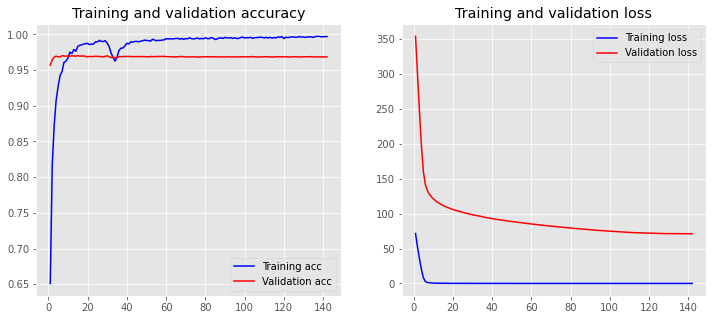

6/6 [==============================] - 3s 75ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8317757009345794,0.9081632653061225,0.8682926829268293,98.0
Apparatus-Descriptor,0.6666666666666666,0.4444444444444444,0.5333333333333333,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.6206896551724138,0.6666666666666666,0.6428571428571429,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5151515151515151,0.85,0.6415094339622641,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9545454545454546,0.9655172413793104,0.96,87.0
Material,0.6324324324324324,0.740506329113924,0.6822157434402332,316.0
Material-Descriptor,0.4895833333333333,0.5280898876404494,0.5081081081081081,89.0
Meta,0.09523809523809523,0.15384615384615385,0.11764705882352941,13.0

In [13]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3507 words (3132 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 140, 100)          664000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 835,292
Trainable params: 835,292
Non-trainable para

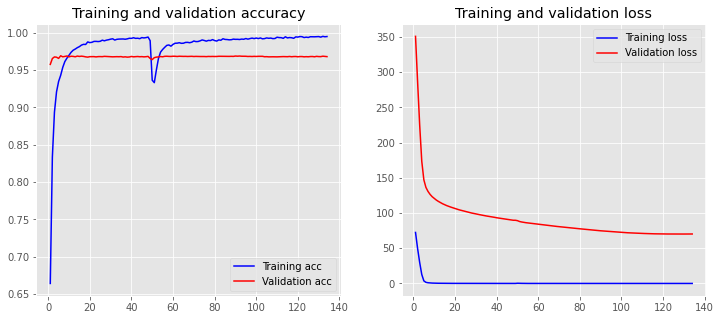

6/6 [==============================] - 3s 74ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.84375,0.826530612244898,0.8350515463917526,98.0
Apparatus-Descriptor,0.7142857142857143,0.5555555555555556,0.6250000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5862068965517241,0.6296296296296297,0.6071428571428571,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.53125,0.85,0.6538461538461537,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6353591160220995,0.7278481012658228,0.6784660766961652,316.0
Material-Descriptor,0.47,0.5280898876404494,0.4973544973544973,89.0
Meta,0.2727272727272727,0.23076923076923078,0.24999999999999994,13.0
Nonrecipe-Material,0.3076923076923077,0.32,0.31372549

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3517 words (3126 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 140, 100)          664400    
                                                                 
 bidirectional_11 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 835,692
Trainable params: 835,692
Non-trainable para

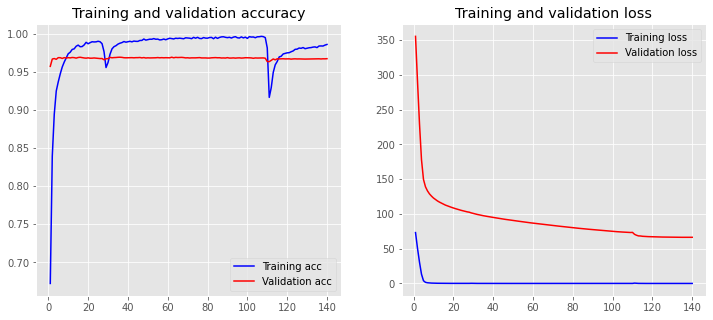

6/6 [==============================] - 3s 73ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.7478260869565218,0.8775510204081632,0.8075117370892018,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.07692307692307693,0.125,13.0
Brand,0.4583333333333333,0.4074074074074074,0.4313725490196078,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6221662468513854,0.7816455696202531,0.6928471248246845,316.0
Material-Descriptor,0.5287356321839081,0.5168539325842697,0.5227272727272728,89.0
Meta,0.3333333333333333,0.38461538461538464,0.3571428571428571,13.0
Nonrecipe-Materia

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3517 words (3129 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 140, 100)          664700    
                                                                 
 bidirectional_12 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 835,992
Trainable params: 835,992
Non-trainable para

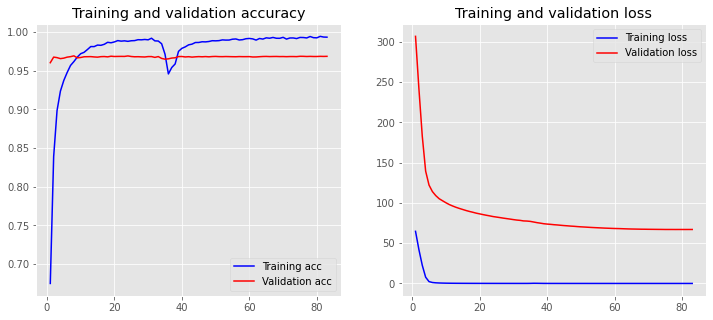

6/6 [==============================] - 3s 73ms/step
F1-score: 70.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8627450980392157,0.8979591836734694,0.8799999999999999,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.7777777777777778,0.5185185185185185,0.6222222222222222,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.8924731182795699,0.9540229885057471,0.9222222222222222,87.0
Material,0.6151832460732984,0.7436708860759493,0.673352435530086,316.0
Material-Descriptor,0.5161290322580645,0.5393258426966292,0.5274725274725275,89.0
Meta,0.2727272727272727,0.23076923076923078,0.24999999999999994,13.0
Nonrecipe-Mat

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3522 words (3130 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 140, 100)          665300    
                                                                 
 bidirectional_13 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 836,592
Trainable params: 836,592
Non-trainable para

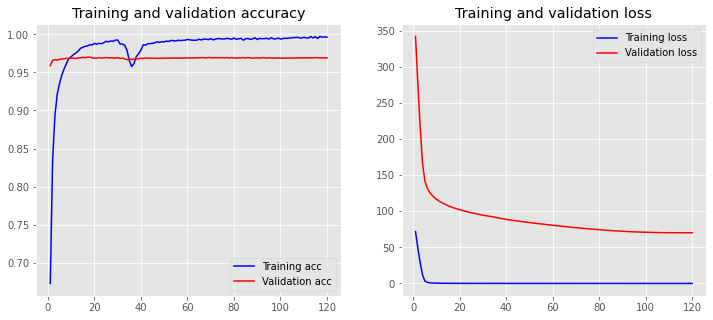

6/6 [==============================] - 4s 73ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.819047619047619,0.8775510204081632,0.8472906403940886,98.0
Apparatus-Descriptor,0.3333333333333333,0.4444444444444444,0.380952380952381,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.6333333333333333,0.7037037037037037,0.6666666666666667,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5161290322580645,0.8,0.6274509803921569,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.6282722513089005,0.759493670886076,0.6876790830945559,316.0
Material-Descriptor,0.4666666666666667,0.47191011235955055,0.4692737430167598,89.0
Meta,0.36363636363636365,0.307692307692307

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3508 words (3130 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 140, 100)          663900    
                                                                 
 bidirectional_14 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 835,192
Trainable params: 835,192
Non-trainable para

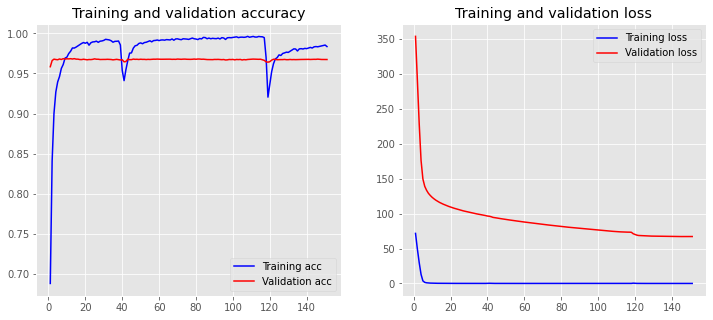

6/6 [==============================] - 3s 75ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8,0.8571428571428571,0.8275862068965518,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.43243243243243246,0.5925925925925926,0.5,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5151515151515151,0.85,0.6415094339622641,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9659090909090909,0.9770114942528736,0.9714285714285714,87.0
Material,0.6413043478260869,0.7468354430379747,0.6900584795321637,316.0
Material-Descriptor,0.49,0.550561797752809,0.5185185185185186,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material,0.2727272727272727,0.24,0.2553191489361702,25.0
Number,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3511 words (3125 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 140, 100)          663700    
                                                                 
 bidirectional_15 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 834,992
Trainable params: 834,992
Non-trainable para

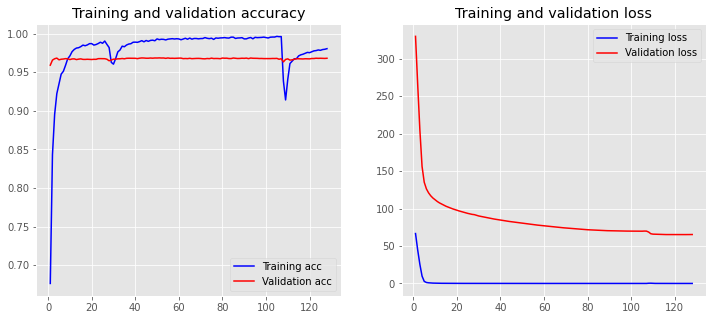

6/6 [==============================] - 4s 74ms/step
F1-score: 70.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8301886792452831,0.8979591836734694,0.8627450980392157,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.3235294117647059,0.4074074074074074,0.36065573770491804,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.06666666666666667,1.0,0.125,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6061381074168798,0.75,0.6704384724186704,316.0
Material-Descriptor,0.4659090909090909,0.4606741573033708,0.4632768361581921,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.238095

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3520 words (3130 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 140, 100)          665100    
                                                                 
 bidirectional_16 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 836,392
Trainable params: 836,392
Non-trainable para

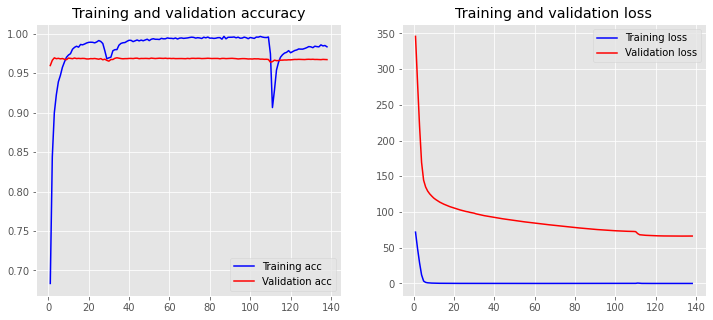

6/6 [==============================] - 3s 77ms/step
F1-score: 69.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3,0.42857142857142855,0.3529411764705882,7.0
Amount-Unit,0.7870370370370371,0.8673469387755102,0.8252427184466019,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.46875,0.5555555555555556,0.5084745762711864,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6253229974160207,0.7658227848101266,0.6884779516358464,316.0
Material-Descriptor,0.45652173913043476,0.47191011235955055,0.46408839779005523,89.0
Meta,0.17647058823529413,0.23076923076923078,0.20000000000000004,13.0
Nonrecipe-Material,0.2,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3528 words (3132 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 140, 100)          666100    
                                                                 
 bidirectional_17 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 837,392
Trainable params: 837,392
Non-trainable para

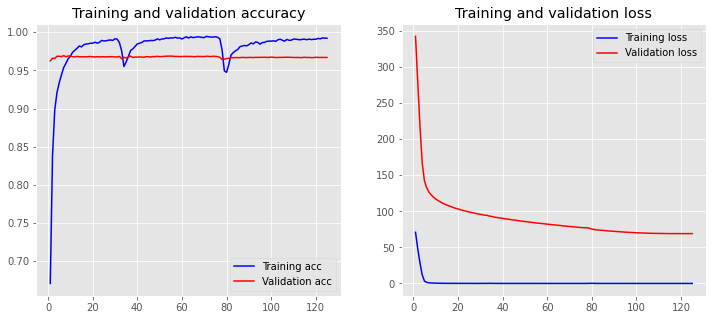

6/6 [==============================] - 4s 74ms/step
F1-score: 70.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8317757009345794,0.9081632653061225,0.8682926829268293,98.0
Apparatus-Descriptor,0.7142857142857143,0.5555555555555556,0.6250000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.3333333333333333,0.5185185185185185,0.40579710144927533,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9318181818181818,0.9425287356321839,0.9371428571428572,87.0
Material,0.6676646706586826,0.7056962025316456,0.6861538461538461,316.0
Material-Descriptor,0.39814814814814814,0.48314606741573035,0.4365482233502538,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3508 words (3126 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 140, 100)          663500    
                                                                 
 bidirectional_18 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 834,792
Trainable params: 834,792
Non-trainable para

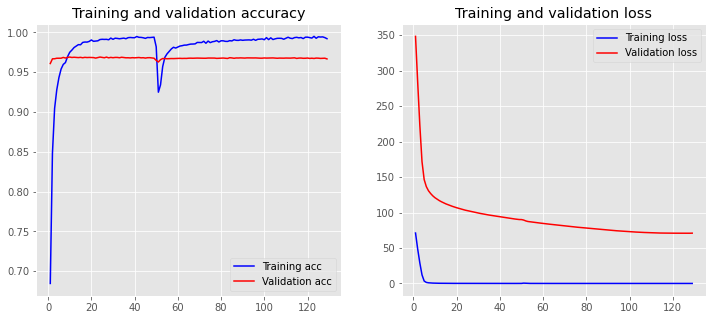

6/6 [==============================] - 3s 72ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8365384615384616,0.8877551020408163,0.8613861386138615,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.46153846153846156,0.4444444444444444,0.4528301886792453,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5,0.85,0.6296296296296295,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.6361185983827493,0.7468354430379747,0.6870451237263464,316.0
Material-Descriptor,0.49473684210526314,0.5280898876404494,0.5108695652173912,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.21428571

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Converted 3507 words (3128 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 140, 100)          663600    
                                                                 
 bidirectional_19 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 834,892
Trainable params: 834,892
Non-trainable para

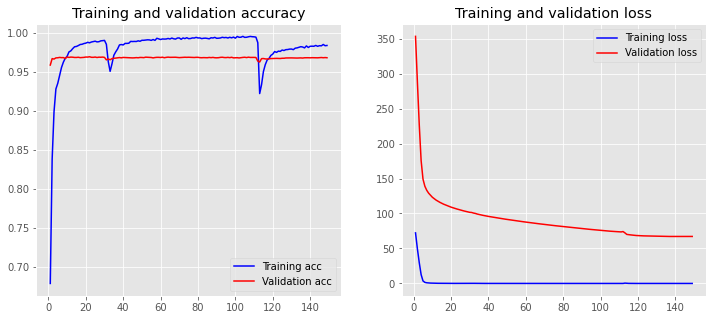

6/6 [==============================] - 4s 73ms/step
F1-score: 69.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.15384615384615385,0.2857142857142857,0.2,7.0
Amount-Unit,0.780952380952381,0.8367346938775511,0.8078817733990147,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.375,0.4444444444444444,0.4067796610169491,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9550561797752809,0.9770114942528736,0.9659090909090908,87.0
Material,0.6030534351145038,0.75,0.6685472496473907,316.0
Material-Descriptor,0.494949494949495,0.550561797752809,0.5212765957446808,89.0
Meta,0.18181818181818182,0.3076923076923077,0.2285714285714286,13.0
Nonrecipe-Materia

In [14]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3534 words (3130 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 140, 100)          666500    
                                                                 
 bidirectional_20 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 837,792
Trainable params: 837,792
Non-trainable para

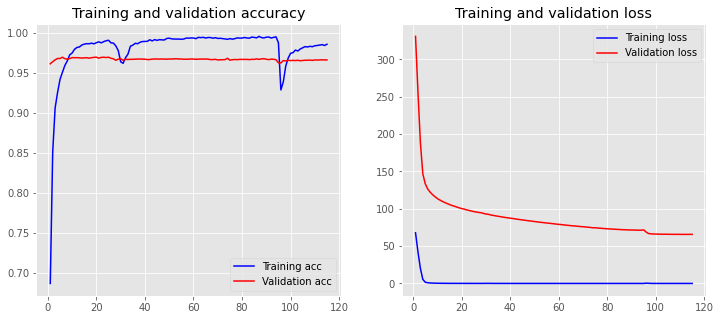

6/6 [==============================] - 4s 85ms/step
F1-score: 69.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.7706422018348624,0.8571428571428571,0.8115942028985508,98.0
Apparatus-Descriptor,0.7142857142857143,0.5555555555555556,0.6250000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.42105263157894735,0.5925925925925926,0.49230769230769234,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5517241379310345,0.8,0.6530612244897959,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6207792207792208,0.7563291139240507,0.6818830242510698,316.0
Material-Descriptor,0.4166666666666667,0.5056179775280899,0.4568527918781726,89.0
Meta,0.14285714285714285,0.23076923076923078,0.17647058823529413,13.0


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3539 words (3137 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 140, 100)          667700    
                                                                 
 bidirectional_21 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 838,992
Trainable params: 838,992
Non-trainable para

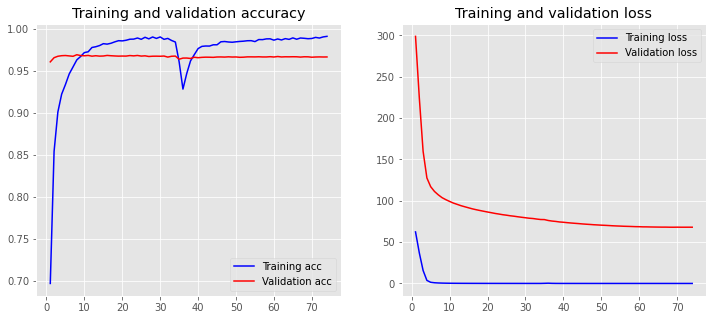

6/6 [==============================] - 4s 83ms/step
F1-score: 69.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.17647058823529413,0.42857142857142855,0.25,7.0
Amount-Unit,0.7272727272727273,0.8163265306122449,0.7692307692307693,98.0
Apparatus-Descriptor,0.6666666666666666,0.4444444444444444,0.5333333333333333,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5833333333333334,0.5185185185185185,0.5490196078431373,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.06666666666666667,1.0,0.125,1.0
Condition-Unit,0.8736842105263158,0.9540229885057471,0.9120879120879121,87.0
Material,0.625,0.7278481012658228,0.672514619883041,316.0
Material-Descriptor,0.5161290322580645,0.5393258426966292,0.5274725274725275,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Material,0.1875,0.24,0.21052631578947367,25.0
Number,0.9154929

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3535 words (3133 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 140, 100)          666900    
                                                                 
 bidirectional_22 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 838,192
Trainable params: 838,192
Non-trainable para

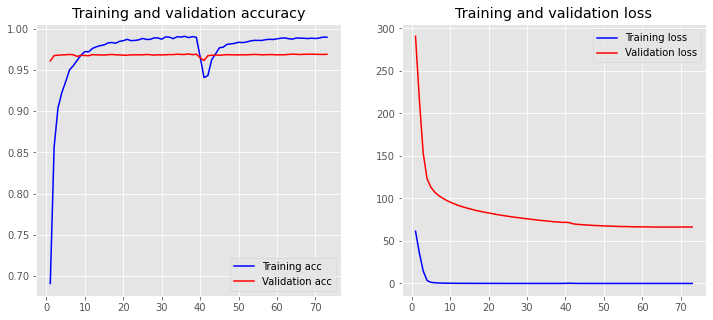

6/6 [==============================] - 3s 81ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.8285714285714286,0.8877551020408163,0.8571428571428572,98.0
Apparatus-Descriptor,0.375,0.3333333333333333,0.35294117647058826,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.5925925925925926,0.5925925925925926,0.5925925925925926,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.6206896551724138,0.9,0.7346938775510204,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9021739130434783,0.9540229885057471,0.9273743016759777,87.0
Material,0.644808743169399,0.7468354430379747,0.6920821114369502,316.0
Material-Descriptor,0.4891304347826087,0.5056179775280899,0.4972375690607735,89.0
Meta,0.2,0.3076923076923077,0.24242424242424246,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3534 words (3130 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 140, 100)          666500    
                                                                 
 bidirectional_23 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 837,792
Trainable params: 837,792
Non-trainable para

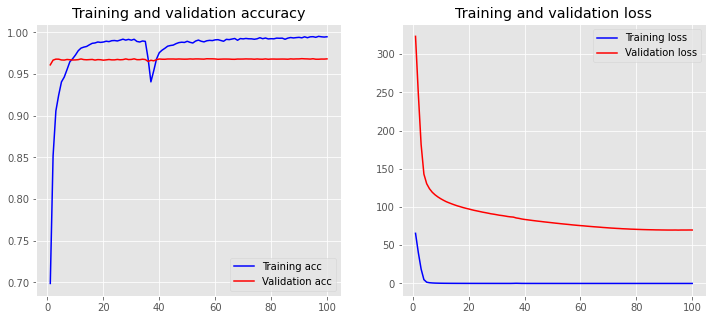

6/6 [==============================] - 4s 82ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.2857142857142857,0.2857142857142857,7.0
Amount-Unit,0.8240740740740741,0.9081632653061225,0.8640776699029127,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5714285714285714,0.5925925925925926,0.5818181818181818,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5862068965517241,0.85,0.6938775510204082,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.6194444444444445,0.7056962025316456,0.6597633136094675,316.0
Material-Descriptor,0.47115384615384615,0.550561797752809,0.5077720207253886,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3533 words (3139 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 140, 100)          667300    
                                                                 
 bidirectional_24 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 838,592
Trainable params: 838,592
Non-trainable para

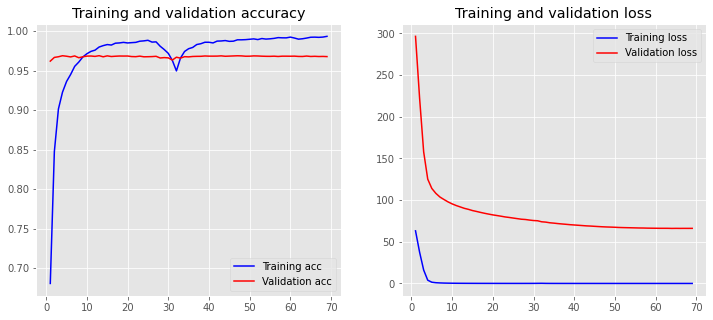

6/6 [==============================] - 3s 77ms/step
F1-score: 70.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8476190476190476,0.9081632653061225,0.876847290640394,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.5185185185185185,0.5185185185185185,0.5185185185185185,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.53125,0.85,0.6538461538461537,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9213483146067416,0.9425287356321839,0.9318181818181818,87.0
Material,0.6047120418848168,0.7310126582278481,0.66189111747851,316.0
Material-Descriptor,0.5232558139534884,0.5056179775280899,0.5142857142857142,89.0
Meta,0.1875,0.23076923076923078,0.20689655172413793,13.0
Nonrecipe-M

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3534 words (3142 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 140, 100)          667700    
                                                                 
 bidirectional_25 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 838,992
Trainable params: 838,992
Non-trainable para

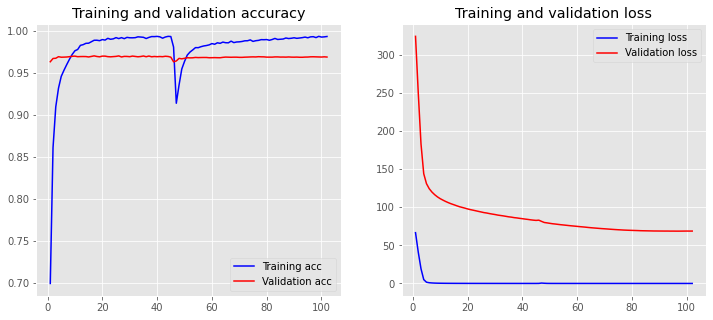

6/6 [==============================] - 3s 78ms/step
F1-score: 70.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8333333333333334,0.8673469387755102,0.8499999999999999,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5555555555555556,0.5555555555555556,0.5555555555555556,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6538461538461539,0.85,0.7391304347826088,20.0
Condition-Type,0.0625,1.0,0.11764705882352941,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.5909090909090909,0.740506329113924,0.6573033707865169,316.0
Material-Descriptor,0.46511627906976744,0.449438202247191,0.45714285714285713,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.0
Nonrecipe-Material,0.2,0.12,0.15,25.0
Number,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3542 words (3135 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 140, 100)          667800    
                                                                 
 bidirectional_26 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 839,092
Trainable params: 839,092
Non-trainable para

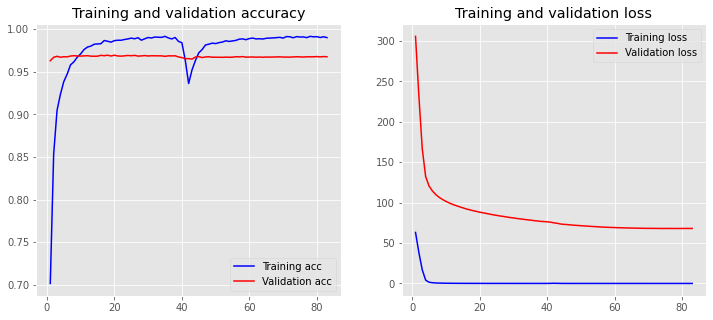

6/6 [==============================] - 3s 76ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.08333333333333333,0.14285714285714285,0.10526315789473685,7.0
Amount-Unit,0.7981651376146789,0.8877551020408163,0.8405797101449275,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.4,0.5185185185185185,0.45161290322580644,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.6153846153846154,0.8,0.6956521739130435,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6240409207161125,0.7721518987341772,0.6902404526166902,316.0
Material-Descriptor,0.4639175257731959,0.5056179775280899,0.4838709677419355,89.0
Meta,0.25,0.38461538461538464,0.30303030303030304,1

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3543 words (3142 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 140, 100)          668600    
                                                                 
 bidirectional_27 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 839,892
Trainable params: 839,892
Non-trainable para

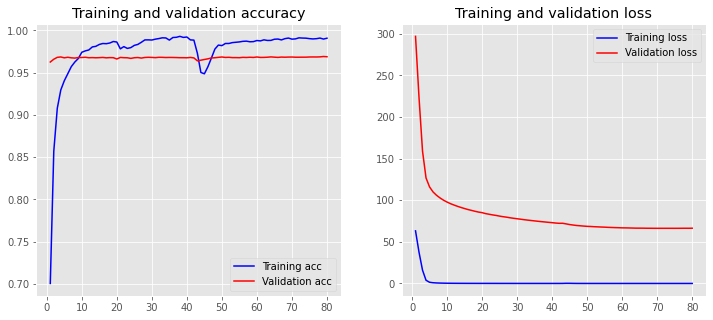

6/6 [==============================] - 4s 78ms/step
F1-score: 71.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.13333333333333333,0.2857142857142857,0.18181818181818182,7.0
Amount-Unit,0.8090909090909091,0.9081632653061225,0.8557692307692307,98.0
Apparatus-Descriptor,0.7142857142857143,0.5555555555555556,0.6250000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5,0.5925925925925926,0.5423728813559322,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9404761904761905,0.9080459770114943,0.9239766081871346,87.0
Material,0.6333333333333333,0.7215189873417721,0.6745562130177515,316.0
Material-Descriptor,0.49504950495049505,0.5617977528089888,0.5263157894736842,89.0
Meta,0.13043478260869565,0.23076923076923078,0.16666666666666669,13

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3549 words (3141 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 140, 100)          669100    
                                                                 
 bidirectional_28 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 840,392
Trainable params: 840,392
Non-trainable para

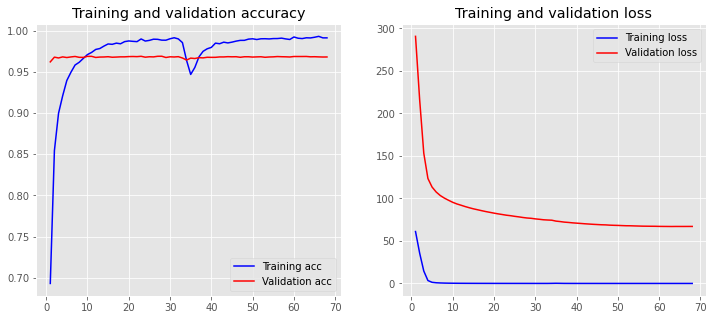

6/6 [==============================] - 4s 76ms/step
F1-score: 70.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.16666666666666666,0.2857142857142857,0.2105263157894737,7.0
Amount-Unit,0.8165137614678899,0.9081632653061225,0.8599033816425121,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.5517241379310345,0.5925925925925926,0.5714285714285714,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.5935960591133005,0.7626582278481012,0.6675900277008311,316.0
Material-Descriptor,0.3939393939393939,0.43820224719101125,0.41489361702127653,89.0
Meta,0.1875,0.23076923076923078,0.20689655172413793,13.0
Nonrecipe-M

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Converted 3540 words (3143 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 140, 100)          668400    
                                                                 
 bidirectional_29 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 839,692
Trainable params: 839,692
Non-trainable para

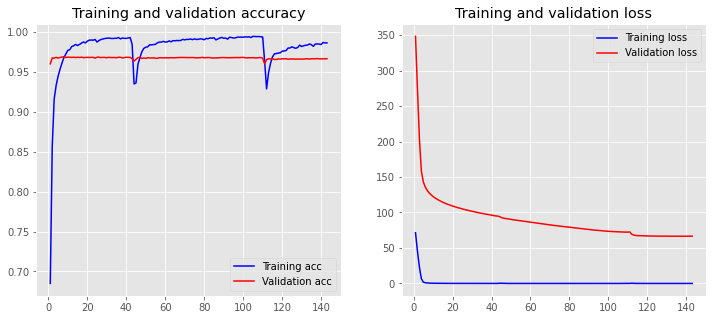

6/6 [==============================] - 3s 76ms/step
F1-score: 70.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.822429906542056,0.8979591836734694,0.8585365853658536,98.0
Apparatus-Descriptor,0.3333333333333333,0.4444444444444444,0.380952380952381,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.3888888888888889,0.5185185185185185,0.4444444444444444,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.8947368421052632,0.9770114942528736,0.9340659340659342,87.0
Material,0.6270718232044199,0.7183544303797469,0.6696165191740413,316.0
Material-Descriptor,0.4883720930232558,0.47191011235955055,0.4799999999999999,89.0
Meta,0.1875,0.23076923076923078,0.20689655172413793,13

In [15]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3568 words (3146 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 140, 100)          671500    
                                                                 
 bidirectional_30 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 842,792
Trainable params: 842,792
Non-trainable pa

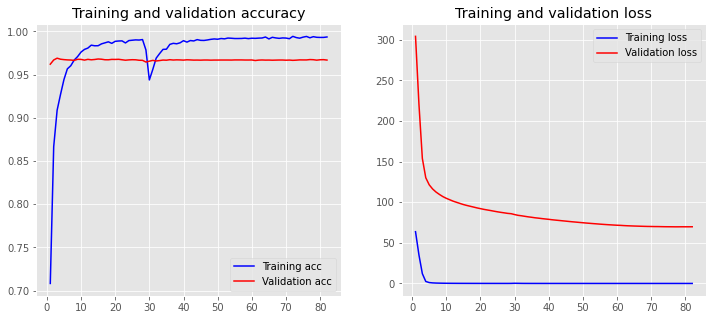

6/6 [==============================] - 3s 76ms/step
F1-score: 70.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8613861386138614,0.8877551020408163,0.8743718592964823,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.3888888888888889,0.5185185185185185,0.4444444444444444,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5,0.85,0.6296296296296295,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.8924731182795699,0.9540229885057471,0.9222222222222222,87.0
Material,0.6235632183908046,0.6867088607594937,0.6536144578313253,316.0
Material-Descriptor,0.4842105263157895,0.5168539325842697,0.5,89.0
Meta,0.1875,0.23076923076923078,0.20689655172413793,13.0
Nonrecipe-Material,0.23529411764705882,0.1

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3550 words (3140 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 140, 100)          669100    
                                                                 
 bidirectional_31 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 840,392
Trainable params: 840,392
Non-trainable pa

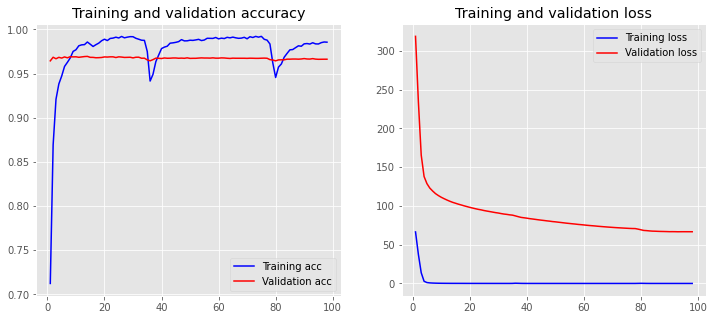

6/6 [==============================] - 3s 79ms/step
F1-score: 70.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.822429906542056,0.8979591836734694,0.8585365853658536,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.45161290322580644,0.5185185185185185,0.48275862068965514,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.53125,0.85,0.6538461538461537,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6141304347826086,0.7151898734177216,0.6608187134502924,316.0
Material-Descriptor,0.5168539325842697,0.5168539325842697,0.5168539325842697,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.0
Nonrecipe-

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3560 words (3153 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 140, 100)          671400    
                                                                 
 bidirectional_32 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 842,692
Trainable params: 842,692
Non-trainable pa

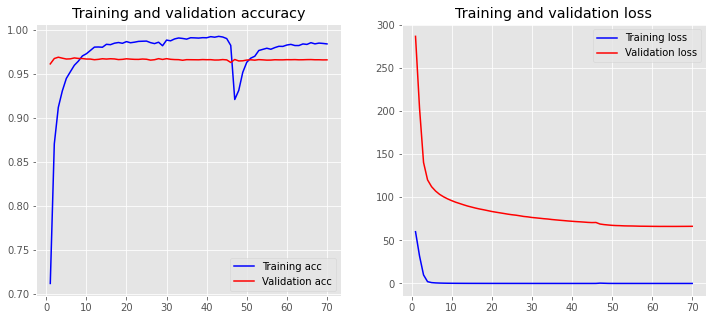

6/6 [==============================] - 3s 74ms/step
F1-score: 69.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.16666666666666666,0.2857142857142857,0.2105263157894737,7.0
Amount-Unit,0.7961165048543689,0.8367346938775511,0.8159203980099503,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.40540540540540543,0.5555555555555556,0.46875,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5142857142857142,0.9,0.6545454545454545,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6058201058201058,0.7246835443037974,0.6599423631123918,316.0
Material-Descriptor,0.4523809523809524,0.42696629213483145,0.4393063583815029,89.0
Meta,0.23529411764705882,0.3076923076923077,0.266

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3557 words (3152 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 140, 100)          671000    
                                                                 
 bidirectional_33 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 842,292
Trainable params: 842,292
Non-trainable pa

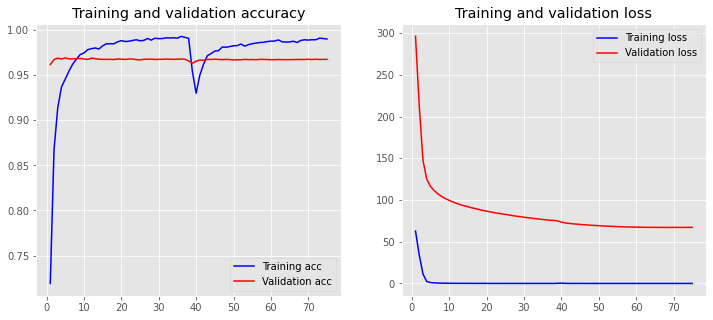

6/6 [==============================] - 3s 76ms/step
F1-score: 70.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8113207547169812,0.8775510204081632,0.8431372549019608,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.4230769230769231,0.4074074074074074,0.4150943396226415,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9438202247191011,0.9655172413793104,0.9545454545454545,87.0
Material,0.6363636363636364,0.7088607594936709,0.6706586826347305,316.0
Material-Descriptor,0.5108695652173914,0.5280898876404494,0.5193370165745856,89.0
Meta,0.2857142857142857,0.3076923076923077,0.2962962

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3555 words (3143 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 140, 100)          669900    
                                                                 
 bidirectional_34 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 841,192
Trainable params: 841,192
Non-trainable pa

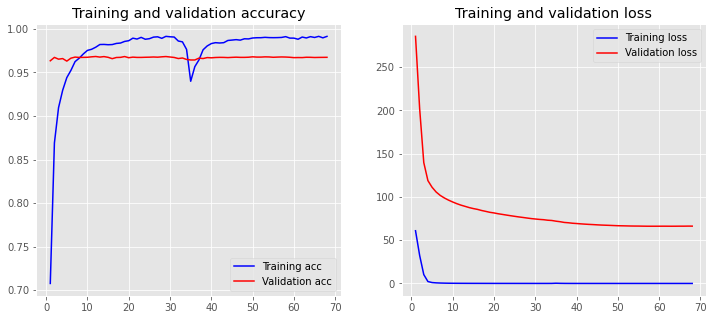

6/6 [==============================] - 4s 76ms/step
F1-score: 70.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.16666666666666666,0.2857142857142857,0.2105263157894737,7.0
Amount-Unit,0.8207547169811321,0.8877551020408163,0.8529411764705883,98.0
Apparatus-Descriptor,0.6,0.6666666666666666,0.631578947368421,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5333333333333333,0.5925925925925926,0.5614035087719299,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.48484848484848486,0.8,0.6037735849056605,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9540229885057471,0.9540229885057471,0.9540229885057472,87.0
Material,0.6260869565217392,0.6835443037974683,0.653555219364599,316.0
Material-Descriptor,0.5617977528089888,0.5617977528089888,0.5617977528089888,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3567 words (3145 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 140, 100)          671300    
                                                                 
 bidirectional_35 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 842,592
Trainable params: 842,592
Non-trainable pa

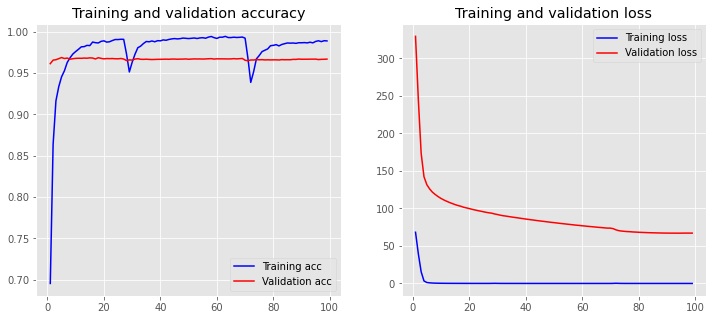

6/6 [==============================] - 3s 76ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.15384615384615385,0.2857142857142857,0.2,7.0
Amount-Unit,0.8627450980392157,0.8979591836734694,0.8799999999999999,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.35294117647058826,0.4444444444444444,0.39344262295081966,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5294117647058824,0.9,0.6666666666666667,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9550561797752809,0.9770114942528736,0.9659090909090908,87.0
Material,0.6030534351145038,0.75,0.6685472496473907,316.0
Material-Descriptor,0.5102040816326531,0.5617977528089888,0.5347593582887701,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3566 words (3148 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 140, 100)          671500    
                                                                 
 bidirectional_36 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 842,792
Trainable params: 842,792
Non-trainable pa

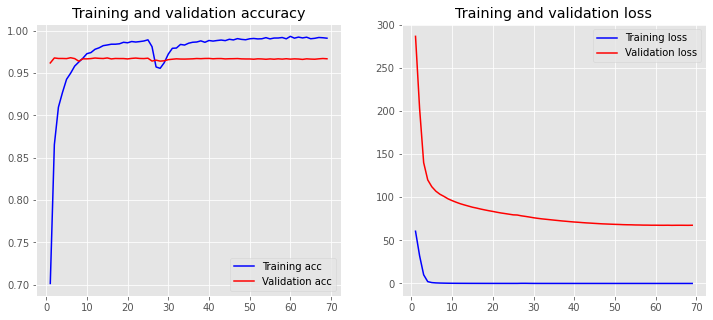

6/6 [==============================] - 4s 74ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8148148148148148,0.8979591836734694,0.8543689320388349,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.6153846153846154,0.5925925925925926,0.6037735849056604,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.6923076923076923,0.9,0.7826086956521738,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6259946949602122,0.7468354430379747,0.6810966810966811,316.0
Material-Descriptor,0.5432098765432098,0.4943820224719101,0.5176470588235293,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.0
N

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3571 words (3143 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 140, 100)          671500    
                                                                 
 bidirectional_37 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 842,792
Trainable params: 842,792
Non-trainable pa

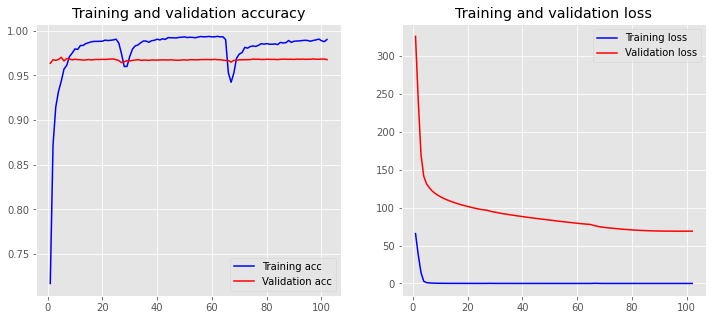

6/6 [==============================] - 4s 82ms/step
F1-score: 71.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8137254901960784,0.8469387755102041,0.8300000000000002,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.6071428571428571,0.6296296296296297,0.6181818181818182,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.658753709198813,0.7025316455696202,0.6799387442572741,316.0
Material-Descriptor,0.44036697247706424,0.5393258426966292,0.48484848484848486,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Mate

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3575 words (3155 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 140, 100)          673100    
                                                                 
 bidirectional_38 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 844,392
Trainable params: 844,392
Non-trainable pa

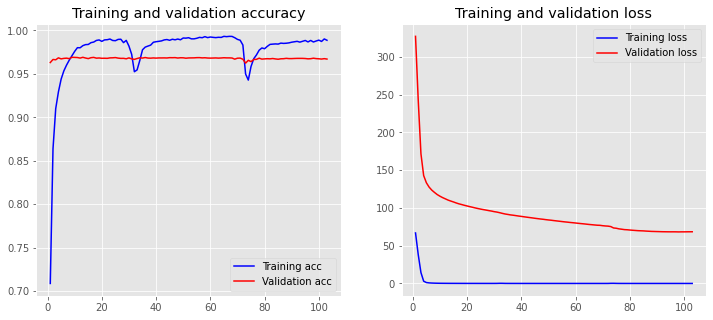

6/6 [==============================] - 3s 78ms/step
F1-score: 69.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.16666666666666666,0.2857142857142857,0.2105263157894737,7.0
Amount-Unit,0.8,0.8571428571428571,0.8275862068965518,98.0
Apparatus-Descriptor,0.6666666666666666,0.6666666666666666,0.6666666666666666,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.4583333333333333,0.4074074074074074,0.4313725490196078,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5555555555555556,0.75,0.6382978723404256,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.6348773841961853,0.7373417721518988,0.6822840409956077,316.0
Material-Descriptor,0.46534653465346537,0.5280898876404494,0.49473684210526314,89.0
Meta,0.1875,0.23076923076923078,0.20689655172413793,1

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Converted 3564 words (3148 misses)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 140, 100)          671300    
                                                                 
 bidirectional_39 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_39 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 842,592
Trainable params: 842,592
Non-trainable pa

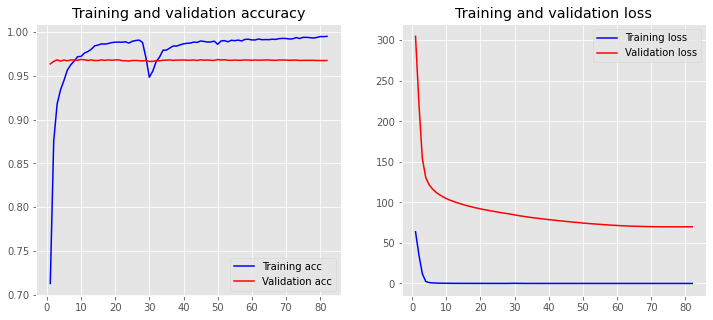

6/6 [==============================] - 4s 75ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.15384615384615385,0.2857142857142857,0.2,7.0
Amount-Unit,0.8823529411764706,0.9183673469387755,0.9,98.0
Apparatus-Descriptor,0.625,0.5555555555555556,0.5882352941176471,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.4444444444444444,0.4444444444444444,0.4444444444444444,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5333333333333333,0.8,0.64,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9431818181818182,0.9540229885057471,0.9485714285714286,87.0
Material,0.6417112299465241,0.759493670886076,0.6956521739130436,316.0
Material-Descriptor,0.4752475247524752,0.5393258426966292,0.5052631578947369,89.0
Meta,0.16666666666666666,0.23076923076923078,0.1935483870967742,13.0
Nonrecipe-Material,0.3,0.24,0.

In [16]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3640 words (3165 misses)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 140, 100)          680600    
                                                                 
 bidirectional_40 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 851,892
Trainable params: 851,892
Non-trainable pa

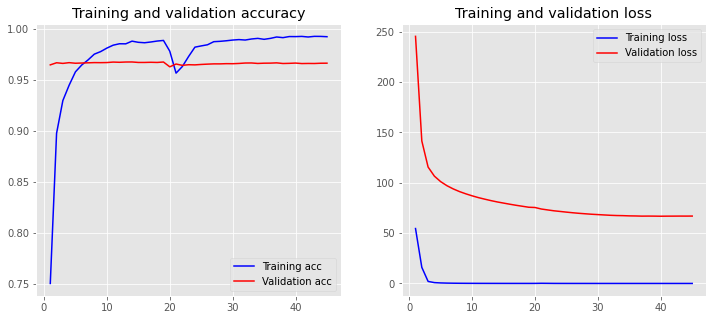

6/6 [==============================] - 3s 71ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8725490196078431,0.9081632653061225,0.89,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.3783783783783784,0.5185185185185185,0.4375,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9425287356321839,0.9425287356321839,0.9425287356321839,87.0
Material,0.6463768115942029,0.7056962025316456,0.6747352496217852,316.0
Material-Descriptor,0.5679012345679012,0.5168539325842697,0.5411764705882354,89.0
Meta,0.36363636363636365,0.3076923076923077,0.33333333333333337,13.0
Nonrecipe-Material,0.15789473684210525,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3628 words (3179 misses)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 140, 100)          680800    
                                                                 
 bidirectional_41 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_41 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_41 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 852,092
Trainable params: 852,092
Non-trainable pa

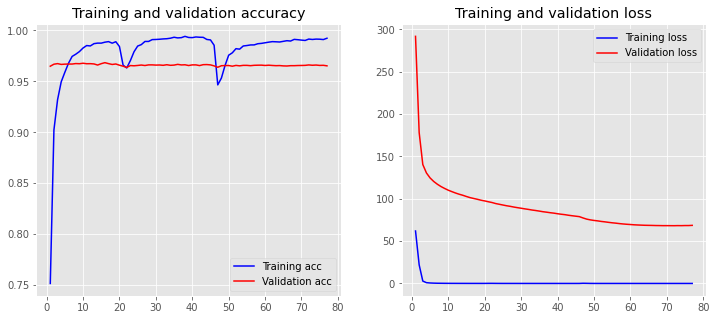

6/6 [==============================] - 4s 79ms/step
F1-score: 70.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.2857142857142857,0.2857142857142857,7.0
Amount-Unit,0.8269230769230769,0.8775510204081632,0.8514851485148514,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.3225806451612903,0.37037037037037035,0.3448275862068965,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9655172413793104,0.9655172413793104,0.9655172413793104,87.0
Material,0.6025974025974026,0.7341772151898734,0.6619115549215405,316.0
Material-Descriptor,0.45454545454545453,0.449438202247191,0.45197740112994345,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3632 words (3178 misses)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 140, 100)          681100    
                                                                 
 bidirectional_42 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_42 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_42 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 852,392
Trainable params: 852,392
Non-trainable pa

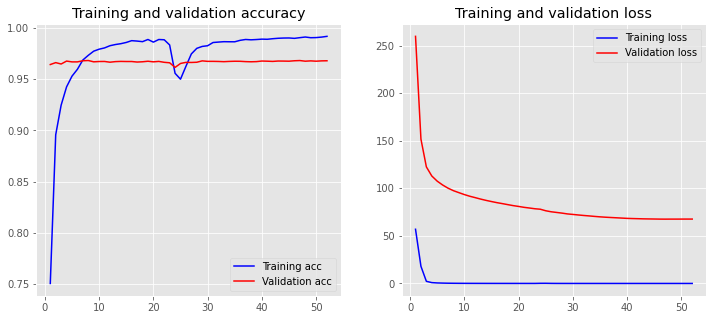

6/6 [==============================] - 4s 76ms/step
F1-score: 69.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.16666666666666666,0.2857142857142857,0.2105263157894737,7.0
Amount-Unit,0.7685185185185185,0.8469387755102041,0.8058252427184466,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.48,0.4444444444444444,0.4615384615384615,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.64,0.8,0.7111111111111111,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9418604651162791,0.9310344827586207,0.9364161849710984,87.0
Material,0.6513761467889908,0.6740506329113924,0.6625194401244169,316.0
Material-Descriptor,0.5066666666666667,0.42696629213483145,0.46341463414634143,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Material,0.2142857

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3622 words (3173 misses)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 140, 100)          679600    
                                                                 
 bidirectional_43 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_43 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_43 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 850,892
Trainable params: 850,892
Non-trainable pa

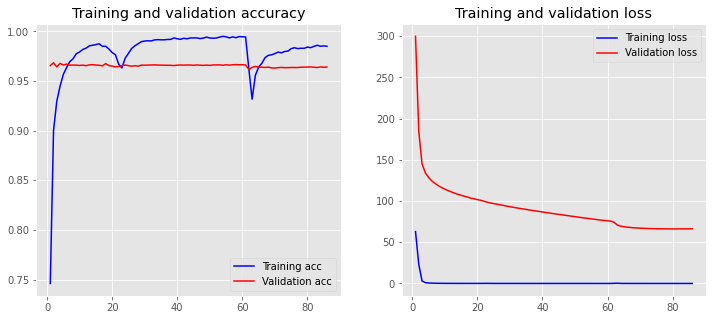

6/6 [==============================] - 4s 74ms/step
F1-score: 70.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8686868686868687,0.8775510204081632,0.8730964467005075,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.5172413793103449,0.5555555555555556,0.5357142857142857,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.6015625,0.7310126582278481,0.66,316.0
Material-Descriptor,0.5492957746478874,0.43820224719101125,0.48750000000000004,89.0
Meta,0.3076923076923077,0.3076923076923077,0.3076923076923077,13.0
Nonrecipe-Material,0.2857142857142857,0.24,0.26086956521

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3615 words (3169 misses)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 140, 100)          678500    
                                                                 
 bidirectional_44 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_44 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_44 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 849,792
Trainable params: 849,792
Non-trainable pa

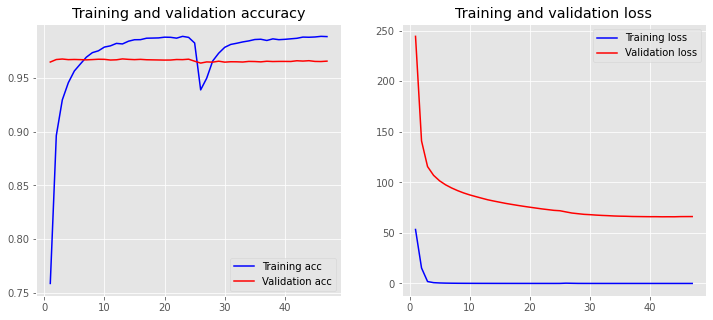

6/6 [==============================] - 4s 76ms/step
F1-score: 69.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.7870370370370371,0.8673469387755102,0.8252427184466019,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.41935483870967744,0.48148148148148145,0.4482758620689655,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9010989010989011,0.9425287356321839,0.9213483146067416,87.0
Material,0.6253521126760564,0.7025316455696202,0.661698956780924,316.0
Material-Descriptor,0.42391304347826086,0.43820224719101125,0.430939226519337,89.0
Meta,0.17647058823529413,0.23076923076923078,0.20000000000000004,13

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3640 words (3176 misses)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 140, 100)          681700    
                                                                 
 bidirectional_45 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_45 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_45 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 852,992
Trainable params: 852,992
Non-trainable pa

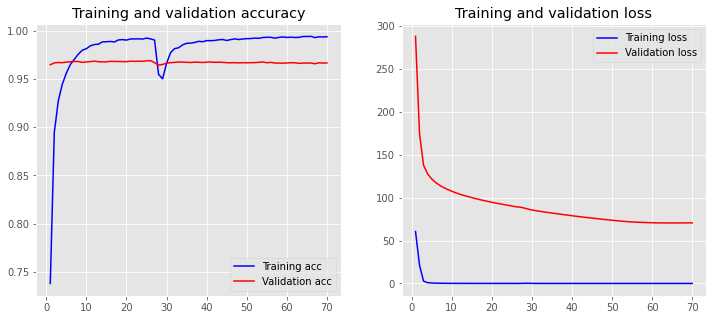

6/6 [==============================] - 3s 78ms/step
F1-score: 70.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.42857142857142855,0.3157894736842105,7.0
Amount-Unit,0.8217821782178217,0.8469387755102041,0.8341708542713568,98.0
Apparatus-Descriptor,0.625,0.5555555555555556,0.5882352941176471,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.3684210526315789,0.5185185185185185,0.4307692307692308,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9010989010989011,0.9425287356321839,0.9213483146067416,87.0
Material,0.6301369863013698,0.7278481012658228,0.6754772393538913,316.0
Material-Descriptor,0.5119047619047619,0.48314606741573035,0.4971098265895953,89.0
Meta,0.3333333333333333,0.38461538461538464,0.3571428571428571,13

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3644 words (3186 misses)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 140, 100)          683100    
                                                                 
 bidirectional_46 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_46 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_46 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 854,392
Trainable params: 854,392
Non-trainable pa

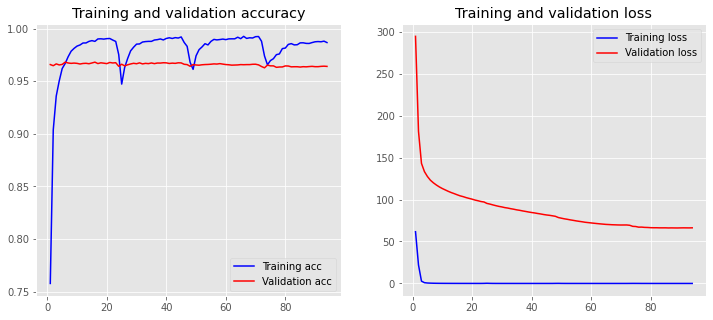

6/6 [==============================] - 3s 74ms/step
F1-score: 69.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8235294117647058,0.8571428571428571,0.84,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.5172413793103449,0.5555555555555556,0.5357142857142857,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6120689655172413,0.6740506329113924,0.641566265060241,316.0
Material-Descriptor,0.40186915887850466,0.48314606741573035,0.4387755102040817,89.0
Meta,0.07692307692307693,0.07692307692307693,0.07692307692307693,13.0
Nonrecipe-Material,0.1666666

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3629 words (3175 misses)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 140, 100)          680500    
                                                                 
 bidirectional_47 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_47 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_47 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 851,792
Trainable params: 851,792
Non-trainable pa

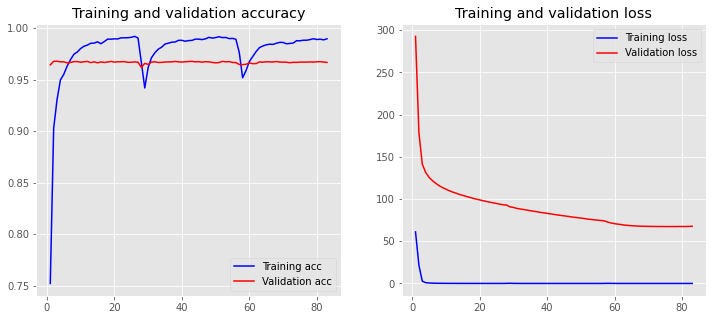

6/6 [==============================] - 3s 68ms/step
F1-score: 68.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.15384615384615385,0.2857142857142857,0.2,7.0
Amount-Unit,0.8080808080808081,0.8163265306122449,0.8121827411167513,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.3333333333333333,0.4074074074074074,0.36666666666666664,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.6296296296296297,0.85,0.723404255319149,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.945054945054945,0.9885057471264368,0.9662921348314606,87.0
Material,0.6102150537634409,0.7183544303797469,0.6598837209302326,316.0
Material-Descriptor,0.46511627906976744,0.449438202247191,0.45714285714285713,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.04,0.04,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3632 words (3165 misses)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 140, 100)          679800    
                                                                 
 bidirectional_48 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_48 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_48 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 851,092
Trainable params: 851,092
Non-trainable pa

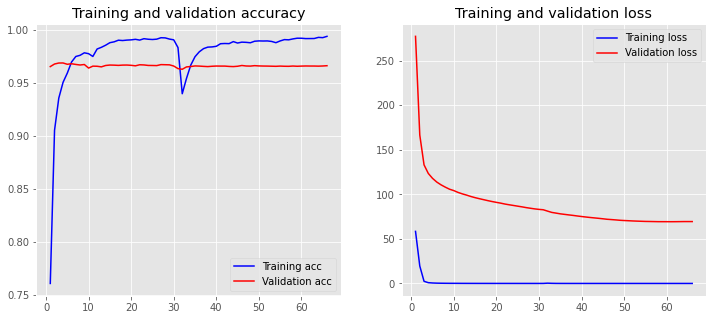

6/6 [==============================] - 4s 76ms/step
F1-score: 70.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8163265306122449,0.8163265306122449,0.8163265306122449,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.4642857142857143,0.48148148148148145,0.4727272727272727,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6428571428571429,0.9,0.75,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.8854166666666666,0.9770114942528736,0.9289617486338797,87.0
Material,0.6141732283464567,0.740506329113924,0.6714490674318507,316.0
Material-Descriptor,0.5,0.5393258426966292,0.518918918918919,89.0
Meta,0.1875,0.23076923076923078,0.20689655172413793,13.0
Nonrecipe-Material,0.13043478260869565,0.1

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3632 words (3164 misses)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 140, 100)          679700    
                                                                 
 bidirectional_49 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_49 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_49 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 850,992
Trainable params: 850,992
Non-trainable pa

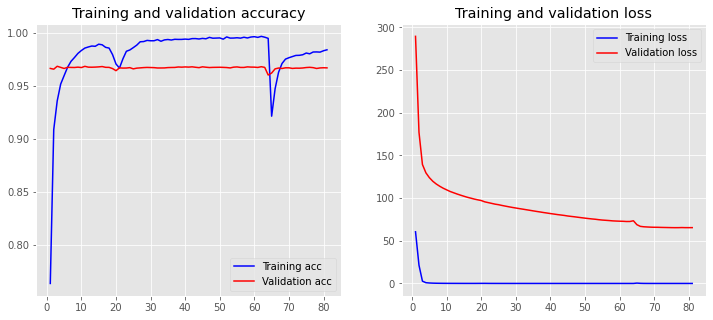

6/6 [==============================] - 4s 79ms/step
F1-score: 68.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.7217391304347827,0.8469387755102041,0.779342723004695,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.5,0.6666666666666666,0.5714285714285715,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.6296296296296297,0.85,0.723404255319149,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6187845303867403,0.7088607594936709,0.6607669616519174,316.0
Material-Descriptor,0.4235294117647059,0.4044943820224719,0.41379310344827586,89.0
Meta,0.4166666666666667,0.38461538461538464,0.4,13.0
Nonrecipe-Material,0.12903225806

In [17]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3814 words (3232 misses)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 140, 100)          704700    
                                                                 
 bidirectional_50 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_50 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_50 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 875,992
Trainable params: 875,992
Non-trainable pa

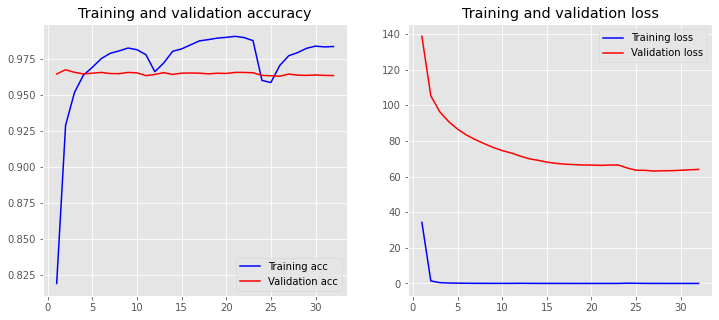

6/6 [==============================] - 3s 75ms/step
F1-score: 68.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.76,0.7755102040816326,0.7676767676767676,98.0
Apparatus-Descriptor,0.8,0.4444444444444444,0.5714285714285714,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.6111111111111112,0.4074074074074074,0.4888888888888889,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6923076923076923,0.9,0.7826086956521738,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6141975308641975,0.629746835443038,0.621875,316.0
Material-Descriptor,0.45454545454545453,0.39325842696629215,0.4216867469879518,89.0
Meta,0.46153846153846156,0.46153846153846156,0.46153846153846156,13.0
Nonrecipe-Material,0.1764705882352941

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3784 words (3212 misses)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 140, 100)          699700    
                                                                 
 bidirectional_51 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_51 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_51 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 870,992
Trainable params: 870,992
Non-trainable pa

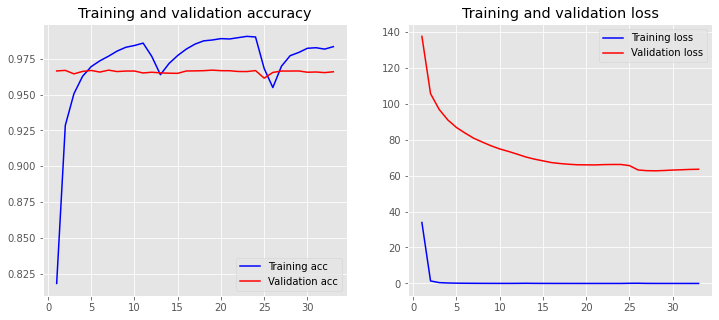

6/6 [==============================] - 3s 74ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.7821782178217822,0.8061224489795918,0.7939698492462313,98.0
Apparatus-Descriptor,0.6666666666666666,0.6666666666666666,0.6666666666666666,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.38095238095238093,0.2962962962962963,0.3333333333333333,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.6206896551724138,0.9,0.7346938775510204,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.8854166666666666,0.9770114942528736,0.9289617486338797,87.0
Material,0.6135693215339233,0.6582278481012658,0.6351145038167939,316.0
Material-Descriptor,0.42857142857142855,0.4044943820224719,0.4161849710982659,89.0
Meta,0.4,0.3076923076923077,0.34782608695652173,13.0
Nonrecipe-Material,0.3703703703

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3773 words (3220 misses)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 140, 100)          699400    
                                                                 
 bidirectional_52 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_52 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_52 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 870,692
Trainable params: 870,692
Non-trainable pa

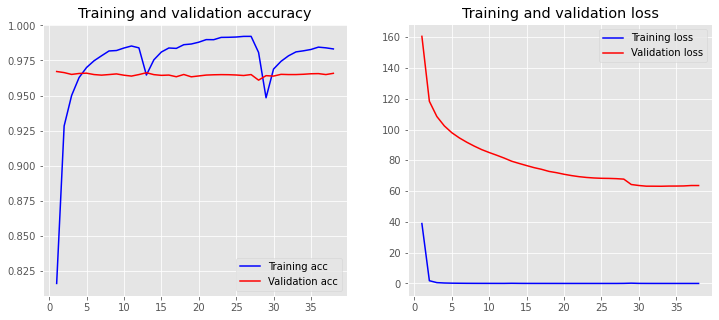

6/6 [==============================] - 3s 70ms/step
F1-score: 67.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.75,0.7959183673469388,0.7722772277227722,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.27586206896551724,0.2962962962962963,0.2857142857142857,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9438202247191011,0.9655172413793104,0.9545454545454545,87.0
Material,0.6096096096096096,0.6424050632911392,0.62557781201849,316.0
Material-Descriptor,0.578125,0.4157303370786517,0.4836601307189543,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.1875,0.12,0.1463414

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3796 words (3222 misses)
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, 140, 100)          701900    
                                                                 
 bidirectional_53 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_53 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_53 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 873,192
Trainable params: 873,192
Non-trainable pa

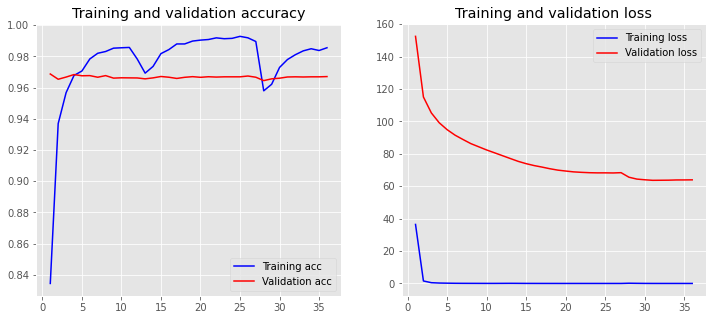

6/6 [==============================] - 3s 71ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8163265306122449,0.8163265306122449,0.8163265306122449,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.4166666666666667,0.37037037037037035,0.39215686274509803,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.8829787234042553,0.9540229885057471,0.9171270718232043,87.0
Material,0.6234567901234568,0.6392405063291139,0.63125,316.0
Material-Descriptor,0.5733333333333334,0.48314606741573035,0.524390243902439,89.0
Meta,0.2222222222222222,0.15384615384615385,0.18181818181818185,13.0
Nonrecipe-Material,0.19047

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3809 words (3226 misses)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, 140, 100)          703600    
                                                                 
 bidirectional_54 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_54 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_54 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 874,892
Trainable params: 874,892
Non-trainable pa

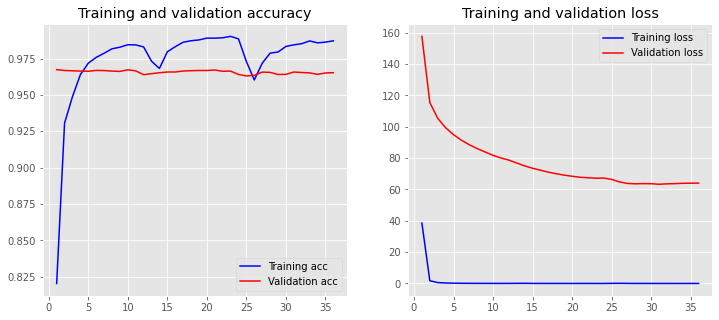

6/6 [==============================] - 3s 73ms/step
F1-score: 68.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.7431192660550459,0.826530612244898,0.782608695652174,98.0
Apparatus-Descriptor,0.8,0.4444444444444444,0.5714285714285714,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.36666666666666664,0.4074074074074074,0.38596491228070173,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.8804347826086957,0.9310344827586207,0.9050279329608939,87.0
Material,0.5888594164456233,0.7025316455696202,0.6406926406926406,316.0
Material-Descriptor,0.4626865671641791,0.34831460674157305,0.3974358974358975,89.0
Meta,0.18181818181818182,0.15384615384615385,0.16666666666666669,13.0
Nonrecipe-Material,0.2857142

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3786 words (3219 misses)
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 140, 100)          700600    
                                                                 
 bidirectional_55 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_55 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_55 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 871,892
Trainable params: 871,892
Non-trainable pa

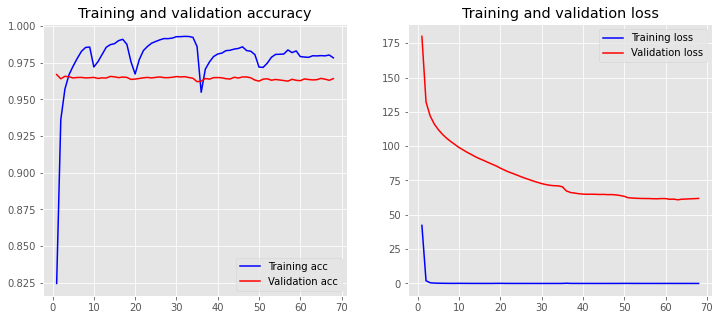

6/6 [==============================] - 3s 74ms/step
F1-score: 66.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8137254901960784,0.8469387755102041,0.8300000000000002,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.25806451612903225,0.2962962962962963,0.27586206896551724,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9010989010989011,0.9425287356321839,0.9213483146067416,87.0
Material,0.5946745562130178,0.6360759493670886,0.6146788990825688,316.0
Material-Descriptor,0.42857142857142855,0.4044943820224719,0.4161849710982659,89.0
Meta,0.25,0.15384615384615385,0.1904761904761905,13.0
Nonrecipe-Ma

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3797 words (3222 misses)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, 140, 100)          702000    
                                                                 
 bidirectional_56 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_56 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_56 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 873,292
Trainable params: 873,292
Non-trainable pa

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3813 words (3216 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 100)          703000    
                                                                 
 bidirectional (Bidirectiona  (None, 140, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 140, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 140, 43)           1849      
                                                                 
Total params: 874,292
Trainable params: 874,292
Non-trainable param

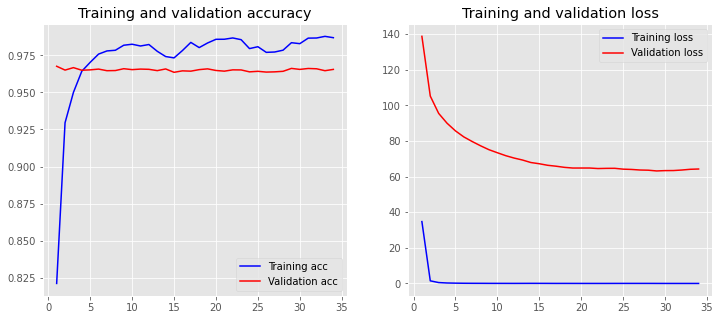

6/6 [==============================] - 3s 75ms/step
F1-score: 67.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.15384615384615385,0.2857142857142857,0.2,7.0
Amount-Unit,0.8058252427184466,0.8469387755102041,0.8258706467661691,98.0
Apparatus-Descriptor,0.8,0.4444444444444444,0.5714285714285714,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.48,0.4444444444444444,0.4615384615384615,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9770114942528736,0.9770114942528736,0.9770114942528736,87.0
Material,0.5853658536585366,0.6075949367088608,0.5962732919254657,316.0
Material-Descriptor,0.45454545454545453,0.39325842696629215,0.4216867469879518,89.0
Meta,0.4166666666666667,0.38461538461538464,0.4,13.0
Nonrecipe-Material,0.12,0.12,0.12,25.0
Number,0.9150943396226415,0.9150943

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3815 words (3228 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 140, 100)          704400    
                                                                 
 bidirectional_1 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 875,692
Trainable params: 875,692
Non-trainable par

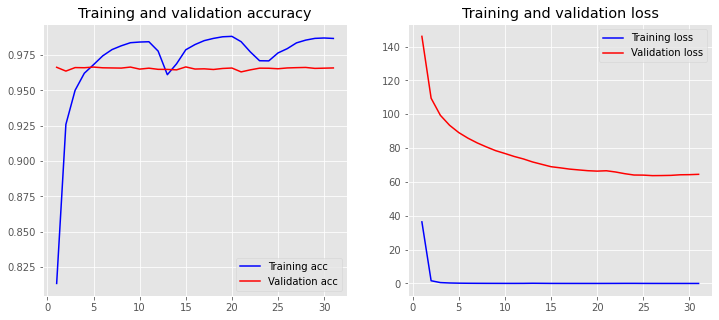

6/6 [==============================] - 3s 78ms/step
F1-score: 68.3%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.7714285714285715,0.826530612244898,0.7980295566502463,98.0
Apparatus-Descriptor,0.7142857142857143,0.5555555555555556,0.6250000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.23529411764705882,0.2962962962962963,0.2622950819672131,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5357142857142857,0.75,0.6250000000000001,20.0
Condition-Type,0.16666666666666666,1.0,0.2857142857142857,1.0
Condition-Unit,0.9213483146067416,0.9425287356321839,0.9318181818181818,87.0
Material,0.6335403726708074,0.6455696202531646,0.6394984326018809,316.0
Material-Descriptor,0.5061728395061729,0.4606741573033708,0.4823529411764706,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.25,0.28,0.2641509433962264,25.0
Number,0.9310344827586207,0.8915094339622641,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3804 words (3218 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 140, 100)          702300    
                                                                 
 bidirectional_2 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 873,592
Trainable params: 873,592
Non-trainable par

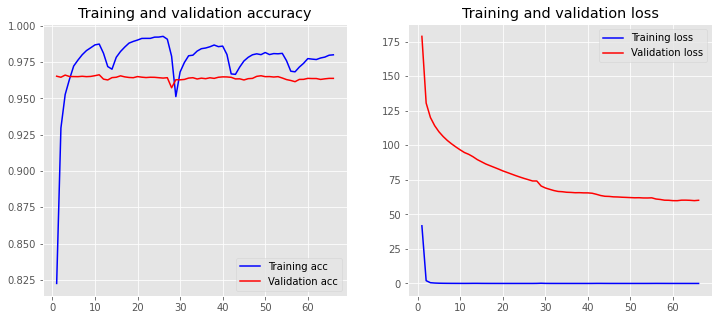

6/6 [==============================] - 3s 76ms/step
F1-score: 67.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.7961165048543689,0.8367346938775511,0.8159203980099503,98.0
Apparatus-Descriptor,0.8333333333333334,0.5555555555555556,0.6666666666666667,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.4666666666666667,0.25925925925925924,0.33333333333333337,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5862068965517241,0.85,0.6938775510204082,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.8585858585858586,0.9770114942528736,0.9139784946236559,87.0
Material,0.571830985915493,0.6424050632911392,0.6050670640834576,316.0
Material-Descriptor,0.4235294117647059,0.4044943820224719,0.41379310344827586,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3812 words (3211 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 140, 100)          702400    
                                                                 
 bidirectional_3 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 873,692
Trainable params: 873,692
Non-trainable par

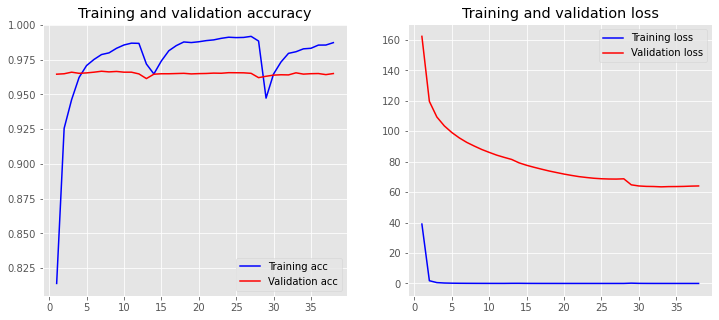

6/6 [==============================] - 3s 76ms/step
F1-score: 67.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8415841584158416,0.8673469387755102,0.8542713567839196,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.4375,0.25925925925925924,0.3255813953488372,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5555555555555556,0.75,0.6382978723404256,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6530612244897959,0.6075949367088608,0.6295081967213114,316.0
Material-Descriptor,0.509090909090909,0.3146067415730337,0.3888888888888889,89.0
Meta,0.15384615384615385,0.15384615384615385,0.15384615384615385,13.

In [13]:
number_of_training_models = 4
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)